# Pricing an Asian Option

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

### Set Parameters

In [2]:
T = [1,5]
m = [4,20]
S0 = 100
r = 0.05
sigma = 0.2
N = 5000
Ks = np.arange(90, 121)

### Define Functions

#### 1. Function to get Monte Carlo Simulation Price

In [3]:
def monte_carlo_price(S0, K, r, sigma, T, m, N):
    """
    Computes the price of an Asian option using Monte Carlo simulation.
    
    Parameters:
    S0 (float): initial stock price
    K (float): strike price
    r (float): risk-free interest rate
    sigma (float): volatility
    T (float): time to maturity
    m (int): number of time steps
    N (int): number of simulations
    
    Returns:
    float: the estimated price of the Asian Call option
    """
    # Compute time step size
    dt = T / m
    
    # Initialize array to store stock prices
    St = np.zeros((N, m+1))

    # Set S0 as the starting point for simulation in each column
    St[:, 0] = S0 
    
    # Simulate stock price paths using standard Brownian motion
    for i in range(1, m+1):
        # Generate N normally distributed random numbers
        dW = np.random.normal(0, np.sqrt(dt), size=N)
        
        # Update stock prices using the Black-Scholes formula
        St[:, i] = St[:, i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * dW)

    # Compute the Asian option payoffs
    Sti = St[:, 1:]
    prices = np.exp(-r * T) * np.maximum(np.sum(Sti, axis=1) / m - K, 0)
    
    # Save the average values from 5000 simulations in numpy array
    # to be used 
    bach_dist = np.sum(Sti, axis=1) / m
    
    # Compute the estimated price of the Asian option as the mean of the payoffs
    price = np.mean(prices)
    
    # Return Asian Call Option Price and simulation results to be used in Bachelier Model
    return [round(price, 2)], bach_dist

#### 2. Functions to get price through log normal approximation using the Black Scholes Formula

2(a). Black Scholes Formula (used in main function to calculate log normal price)

In [4]:
def black_scholes_formula(S0, sigma, r, T, K):
    """
    Computes the price of a European call option using the Black-Scholes formula.
    
    Parameters:
    S0 (float): initial stock price
    sigma (float): volatility
    r (float): risk-free interest rate
    T (float): time to maturity
    K (float): strike price
    
    Returns:
    float: the estimated price of the call option
    """
    # Compute d1 and d2, which are intermediate variables used in the Black-Scholes formula
    d1 = (math.log(S0/K) + (r + (sigma**2/2))*(T)) / (math.sqrt(T)*sigma)
    d2 = d1 - (math.sqrt(T) * sigma)
    
    # Compute the price of the call option using the Black-Scholes formula
    C = (S0 * norm.cdf(d1)) - (K * math.exp(-r*T) * norm.cdf(d2))
    
    # Round the estimated price to two decimal places and return it
    return round(C, 2)

2(b). Formula to calculate M2 used in log normal approximation pricing

In [5]:
def calculate_M2(r, dt, sigma, S0, m):
    """
    Calculates the second moment of the stock price at maturity using the Euler-Maruyama discretization.
    
    Parameters:
    r (float): the risk-free interest rate
    dt (float): the time step size
    sigma (float): the volatility of the stock price
    S0 (float): the initial stock price
    m (int): the number of time steps
    
    Returns:
    float: the estimated second moment of the stock price at maturity
    """
    M2 = 0  # Initialize the second moment
    
    # Compute the sum of the cross terms of the Euler-Maruyama discretization
    for j in range(1, m+1):
        for i in range(1, j):
            M2 += 2 * ((S0 * np.exp(r*i*dt)) * (S0 * np.exp(r*j*dt)) * (np.exp((sigma ** 2) * i * dt)))
    
    # Compute the sum of the squared terms of the Euler-Maruyama discretization
    for i in range(1, m+1):
        M2 += ((S0 * np.exp(r*i*dt))**2) * np.exp((sigma**2)*(i*dt))
    
    # Compute the estimated second moment by dividing by the square of the number of time steps
    return (M2 / (m**2))

2(c). Main function to calculate log normal price

In [6]:
def log_normal_price(S0, K, r, sigma, T, m):
    """
    Computes the price of an Asian option using the log-normal approximation method.
    
    Parameters:
    S0 (float): the initial stock price
    K (float): the strike price
    r (float): the risk-free interest rate
    sigma (float): the volatility of the stock price
    T (float): the time to maturity of the option
    m (int): the number of time steps
    
    Returns:
    float: the estimated price of the Asian option using the log-normal approximation method
    """
    # Compute time step size
    dt = T/m
    
    # Compute the first moment of the stock price at maturity
    M1 = np.sum(np.array([S0*np.exp(r*i*dt) for i in range(1, m+1)])) / m
    
    # Compute the second moment of the stock price at maturity by calling the calculate_M2 function defined above
    M2 = calculate_M2(r, dt, sigma, S0, m)
    
    # Compute the estimated volatility and drift of the stock price using the log-normal approximation method
    sigma_hat = math.sqrt((1/T) * math.log(M2 / (M1**2)))
    S0_hat = M1 * np.exp(-r * T)
    
    # Use the estimated volatility and drift to compute the price of the Asian option using the Black-Scholes formula
    return black_scholes_formula(S0_hat, sigma_hat, r, T, K)

#### 3. Function to get prices with normal approximation using the Bachelier Call Formula

In [7]:
def bachelier_price(bach_dist, K, r, T):
    """
    Computes the price of an Asian option using the Bachelier Normal approximation method.
    
    Parameters:
    S0 (float): the initial stock price
    K (float): the strike price
    r (float): the risk-free interest rate
    sigma (float): the volatility of the stock price
    T (float): the time to maturity of the option
    
    Returns:
    float: the estimated price of the Asian option using the Normal approximation method
    """

    # Calculate F and sigma for bachelier distribution
    Fb = bach_dist.mean()
    sigmaB = bach_dist.std()
    
    # Calculate the standardized normal variable
    Z = (Fb - K) / (sigmaB)
    
    # Use the Bachelier Call formula to calculate the option price
    C = np.exp(-r*T) * ((Fb - K)*norm.cdf(Z) + (sigmaB * norm.pdf(Z, loc=0, scale=1)))
    
    # Round the option price to two decimal places and return
    return round(C, 2)

### Main Code:
    - Fetches the asian option price through three methods defined
    - Runs the code of a range of strike prices and for different combinations of (T, m)
    - Stores the results in a dataframe and prints it

In [8]:
# Initialize two empty dictionaries to store Asian option call prices for two different values of (T,m) i.e. (1,4) and (5,20)
asian_option_1_4 = {}
asian_option_5_20 = {}

# For each strike price (K), fetch the call option prices using
# Monte Carlo, log normal, and Bachelier pricing models for the two different (T,m) values

for K in Ks:
    # For (1,4) calculate the call option prices and store in the dictionary asian_option_1_4
    asian_option_1_4[K], bach_dist_1 = monte_carlo_price(S0, K, r, sigma, T[0], m[0], N)
    asian_option_1_4[K].append(log_normal_price(S0, K, r, sigma, T[0], m[0]))
    asian_option_1_4[K].append(bachelier_price(bach_dist_1, K, r, T[0]))
    
    # For (5,20) calculate the call option prices and store in the dictionary asian_option_5_20
    asian_option_5_20[K], bach_dist_2 = monte_carlo_price(S0, K, r, sigma, T[1], m[1], N)
    asian_option_5_20[K].append(log_normal_price(S0, K, r, sigma, T[1], m[1]))
    asian_option_5_20[K].append(bachelier_price(bach_dist_2, K, r, T[1]))

# Convert the dictionaries asian_option_1_4 and asian_option_5_20 into pandas DataFrames with the strike prices as the index and the prices obtained from each pricing model as columns
asian_price_1_4_df = pd.DataFrame.from_dict(asian_option_1_4, orient='index', columns=['Monte Carlo', 'log normal','Bachelier'])
asian_price_5_20_df = pd.DataFrame.from_dict(asian_option_5_20, orient='index', columns=['Monte Carlo', 'log normal','Bachelier'])

# Rename the index of the DataFrames to 'Strike'
asian_price_1_4_df = asian_price_1_4_df.rename_axis('Strike')
asian_price_5_20_df = asian_price_5_20_df.rename_axis('Strike')

In [9]:
# Display asian option prices for So = $100, r = 5%, sigma = 0.2, T = 1 and m = 4
print("Asian Option Price when T = 1 and m = 4:\n\n", asian_price_1_4_df)

Asian Option Price when T = 1 and m = 4:

         Monte Carlo  log normal  Bachelier
Strike                                    
90            13.86       13.61      14.12
91            12.89       12.83      13.12
92            12.34       12.08      12.63
93            11.36       11.35      11.64
94            10.69       10.65      10.93
95             9.43        9.97       9.64
96             9.42        9.31       9.63
97             8.60        8.68       8.78
98             8.07        8.08       8.20
99             7.59        7.50       7.73
100            6.77        6.95       6.85
101            6.39        6.43       6.45
102            6.17        5.94       6.24
103            5.36        5.47       5.37
104            5.07        5.03       5.10
105            4.81        4.61       4.83
106            4.36        4.22       4.33
107            3.62        3.86       3.59
108            3.41        3.52       3.32
109            3.06        3.20       2.94
110        

In [10]:
# Display asian option prices for So = $100, r = 5%, sigma = 0.2, T = 5 and m = 20
print("Asian Option Price when T = 5 and m = 20:\n\n", asian_price_5_20_df)

Asian Option Price when T = 5 and m = 20:

         Monte Carlo  log normal  Bachelier
Strike                                    
90            20.84       21.29      22.09
91            20.52       20.70      21.61
92            20.39       20.12      21.64
93            19.71       19.55      20.86
94            18.54       18.99      19.67
95            18.12       18.44      19.18
96            17.34       17.90      18.39
97            17.10       17.37      18.24
98            16.98       16.84      17.95
99            16.33       16.34      17.11
100           15.93       15.84      17.01
101           15.78       15.35      16.65
102           14.57       14.87      15.58
103           14.59       14.40      15.38
104           13.30       13.94      14.13
105           13.73       13.50      14.45
106           12.83       13.06      13.41
107           12.65       12.64      13.45
108           12.17       12.22      12.66
109           11.59       11.82      12.11
110       

### Conclusion:

At T = 1, all three prices almost overlap and give similar results. Based on the analysis conducted, it can be concluded that for shorter periods, both the log-normal and Bachelier approximation methods provide accurate results, with the log-normal method performing slightly better. However, as the time to maturity increases, the Bachelier method begins to produce prices with larger errors, while the log-normal method continues to provide good estimates. This is evident from the fact that, at T = 5 years, the log-normal prices closely match the Monte Carlo estimates, while the Bachelier prices exhibit relatively poor results. Hence, for longer time periods, the log-normal method is more reliable in accurately estimating prices.

### Additional Analysis by plotting

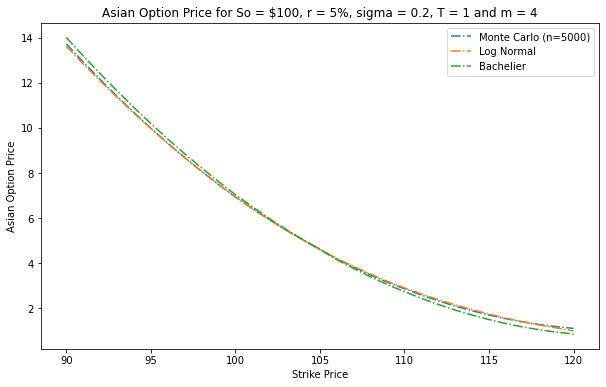

In [11]:
""" 
Plot Asian Option Price obtained through 
Monte Carlo Simulation (n = 5000), Log Normal Approximation and Bachelier Normal Approximation
when T = 1 and m = 4
"""
# Apply Savitzky-Golay filter to smoothen the line
asian_price_1_4_df['Monte Carlo Smooth'] = savgol_filter(asian_price_1_4_df['Monte Carlo'], window_length=21, polyorder=2)
asian_price_1_4_df['Bachelier Smooth'] = savgol_filter(asian_price_1_4_df['Bachelier'], window_length=21, polyorder=2)

# Define the figure and axes objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the three columns against the index
asian_price_1_4_df.plot(ax=ax, y=['Monte Carlo Smooth', 'log normal', 'Bachelier Smooth'], linestyle=('-.'))

# Set the labels and title
ax.set_xlabel('Strike Price')
ax.set_ylabel('Asian Option Price')
ax.set_title('Asian Option Price for So = $100, r = 5%, sigma = 0.2, T = 1 and m = 4')

# Add the legend
ax.legend(['Monte Carlo (n=5000)', 'Log Normal', 'Bachelier'])

# Show the plot
plt.show()

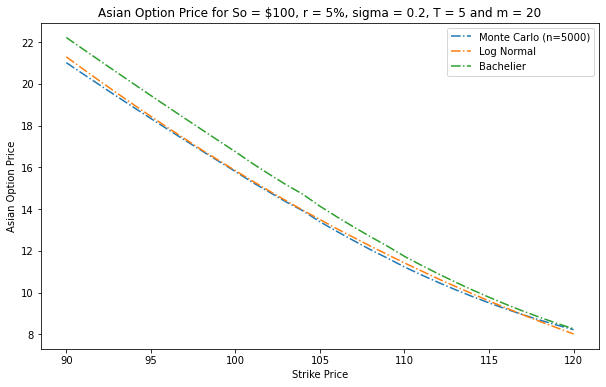

In [12]:
""" 
Plot Asian Option Price obtained through 
Monte Carlo Simulation (n = 5000), Log Normal Approximation and Bachelier Normal Approximation
when T = 5 and m = 20
"""
# Apply Savitzky-Golay filter to smoothen the line
asian_price_5_20_df['Monte Carlo Smooth'] = savgol_filter(asian_price_5_20_df['Monte Carlo'], window_length=21, polyorder=2)
asian_price_5_20_df['Bachelier Smooth'] = savgol_filter(asian_price_5_20_df['Bachelier'], window_length=21, polyorder=2)

# Define the figure and axes objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the three columns against the index
asian_price_5_20_df.plot(ax=ax, y=['Monte Carlo Smooth', 'log normal', 'Bachelier Smooth'], linestyle=('-.'))

# Set the labels and title
ax.set_xlabel('Strike Price')
ax.set_ylabel('Asian Option Price')
ax.set_title('Asian Option Price for So = $100, r = 5%, sigma = 0.2, T = 5 and m = 20')

# Add the legend
ax.legend(['Monte Carlo (n=5000)', 'Log Normal', 'Bachelier'])

# Show the plot
plt.show()